# A write-up for Google CTF 2019 Qualification Round
-   Challenge: **REALITY**
-   Category: *Cryptography*
-   By: [NDH](https://www.github.com/nguyenduyhieukma)

## 1. Challenge summary

For each connection to *reality.ctfcompetition.com:1337*, we are given 3 points on an unknown, 4th-degree polynomial (over $\mathbb{R}$) [_[1](#q-1),[2](#q-2)_] whose coefficients are integers lying in the range $(0, 2^{128})$ [[_3_](#q-3)]. The points are not accurate since their coordinates are arbitrary real numbers, each represented by a finite number of digits. The task is to recover the polynomial.

This challenge is inspired by [Shamir's secret-sharing scheme](https://en.wikipedia.org/wiki/Shamir%27s_Secret_Sharing). In this scheme, a shared secret is designed to be the constant term of a $k$th-degree polynomial (over a finite field) which can only be reconstructed if k+1 points on the polynomial are given. If there're not enough points, any element of the finite field can be any coefficient of the secret polynomial. In our case, this is not true anymore, since only some integers, out of the set of real numbers, can be the secret polynomial's coefficient. That's why the challenge is solvable, although it seems at first that the points given are not enough.

In order to solve the challenge, we will model it as a closest vector problem in lattice. A quick review about lattice, the problem and how to solve it, is provided below.

## 2. Lattice revisited

### 2.1. Lattice

A lattice in $\mathbb{R}^n$ is a set of linear combinations with integer coefficients of at most $n$ linearly independent vectors: 

$$
\{a_1v_1 + a_2v_2 + \dots + a_kv_k \mid a_1, a_2,... a_k \in \mathbb{Z}; v_1, v_2,... v_k \in \mathbb{R}^n; k \leq n \}
$$

These independent vectors are together called a lattice basis. Different bases may generate the same lattice as shown in [_Figure 1_](#fig-1).

|<a id='fig-1'></a>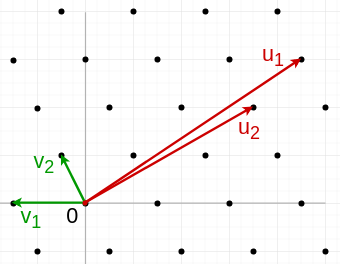|
|---|
|*Figure 1: This lattice (represented by black dots) in $\mathbb{R}^2$ can be constructed from either $\{u_1, u_2\}$ or $\{v_1, v_2\}$.*|

A lattice basis is "good" if it consists of nearly orthogonal, short vectors (like the green ones in [_Figure 1_](#fig-1)). Given an arbitrary lattice basis, we can apply [the LLL algorithm](https://en.wikipedia.org/wiki/Lenstra%E2%80%93Lenstra%E2%80%93Lov%C3%A1sz_lattice_basis_reduction_algorithm) to reduce it to a better one. The basis output by this algorithm may not be the best one, but its running time is guaranteed to be polynomial in the lattice dimension.

### 2.2. Closest vector problem

In a closest vector problem (CVP), we are given a lattice $\mathcal{L}$ with a basis $B$, a target vector $t$, and need to find the vector $v$ in $L$ closest to $t$. An example is given in [_Figure 2_](#fig-2).

|<a id='fig-2'></a>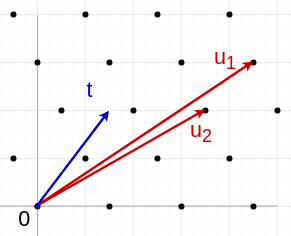|
|---|
|*Figure 2: An example of CVP: the lattice is represented by black dots, the basis vectors are in red and the target vector is in blue.*|

We can approximately and efficiently solve this kind of problem by taking the following actions:
1.  Project $t$ onto the vector space $V$ spanned by $B$, obtain $\bar{t}$ which is the vector in $V$ closest to $t$.
2.  Apply the LLL algorithm on $B$, obtain a better basis $\bar{B}$.
3.  Find the exact linear combination of $\bar{u_i}$'s in $\bar{B}$ that produces $\bar{t}$, obtain the coefficients $c_i$'s.
4.  Round each $c_i$ to its nearest integer, obtain $\bar{c_i}$'s.
5.  Output $v = \bar{c_1}\bar{u_1} + \bar{c_2}\bar{u_2} + \dots$

Let's implement this strategy in SageMath:

In [1]:
def solve_cvp(B, t, verbose=False):
    """
    This function approximately and efficiently solves the closest vector problem.
    
    Arguments:
        B: a matrix whose rows are the basis vectors.
        t: the target vector.
        verbose: if True, print out useful information while solving the problem.
    
    Return:
        A vector in the lattice generated by `B` (approximately) closest to `t`.
        
    """
    #  perform vector projecting using the Gram-Schmidt process
    t_ = t - B.stack(t).gram_schmidt()[0].row(-1)
    if verbose:
        print "Target vector projection:"
        print numerical_approx(t_, digits=5)
    
    # apply the LLL algorithm
    B_ = B.LLL()
    if verbose:
        print "\nLLL-reduced basis:"
        print numerical_approx(B_, digits=5)

    # find the exact linear combination of vectors in `B_` that produces `t_`
    c = B_.solve_left(t_)

    # round each coefficient to its nearest integer
    c_ = vector(map(round, c))
    if verbose:
        print "\nRound-off errors:"
        print numerical_approx(vector(map(abs, c - c_)), digits=5)
    
    # output the result
    return c_ * B_


# testing
B = matrix([
    [7/2, 2, 0],
    [9/2, 3, 0],
])
t = vector([3/2, 2, 1])
solve_cvp(B, t, verbose=True)

Target vector projection:
(1.5000, 2.0000, 0.00000)

LLL-reduced basis:
[0.50000 -1.0000 0.00000]
[ 1.0000  1.0000 0.00000]

Round-off errors:
(0.33333, 0.33333)


(2, 2, 0)

You might notice that the test case above is closely related to [_Figure 2_](#fig-2).

### 2.3. Coordinate scaling

Sometimes, we want to redefine the distance between two vectors. For example, the difference between the x-coordinates may be more important than the one between the y-coordinates, and should contribute more to the total distance between any two vectors. However, the strategy presented in [_Section 2.2_](#2.2.-Closest-vector-problem) only works with [_Euclidean distance_](https://en.wikipedia.org/wiki/Euclidean_distance).

Fortunately, we can scale each coordinate of every vector by a factor (usually a different factor for each coordinate) to adjust the coordinate's "importance degree". For example, if you think the x-coordinate (or the difference between the x-coordinates) is "10 times more important" than the y-coordinate (or the difference between the y-coordinates) in contributing to the length of a vector (or the distance between two vectors), just scale it (the x-coordinate) by a factor of 10 for all vectors before applying any operation to them. Of course, you need to scale it back when the work on the vectors is done.

Let's implement this in our new version of `solve_cvp`:

In [2]:
def solve_cvp2(B, t, scale_factors=None, verbose=False):
    """
    A wrapper of `solve_cvp` to perform coordinate scaling.
    
    Arguments:
        scale_factors: a list of scale factors. The 1st, 2nd, 3rd, ... factor 
            will be used for the 1st, 2nd, 3rd, ... coordinate.
    
    """
    if not scale_factors:
        scale_factors = [1] * B.ncols()
    
    if verbose:
        print "Scale factors:"
        print numerical_approx(vector(scale_factors), digits=5), '\n'
    
    scale_matrix = diagonal_matrix(scale_factors)
    return solve_cvp(B*scale_matrix, t*scale_matrix, verbose) * scale_matrix^-1   

Now, let's see what will happen if we scale the first coordinate of every vector by a factor of 10:

In [3]:
solve_cvp2(B, t, scale_factors=[10, 1, 1])

(3/2, 3, 0)

As you can see, the vector with the least difference in the first coordinate is chosen to be the closest vector instead (the previous one is $(2, 2, 0)$ while the target is $(\frac{3}{2}, 2, 1))$. 

One more thing about `solve_cvp2` we need to remember is that using different lists of scale factors of the same ratio (for example, $[10, 1, 1]$ and $[20, 2, 2]$) will make no changes to the final output. Furthermore, scale factors need not to be strict and can be "tuned" until a reasonable vector is returned.

Now we're ready to solve the challenge!

## 3. Solution details

Let's connect to the server:

```console
nc reality.ctfcompetition.com 1337
```

The received information, including the encrypted flag in base-32 format and the coordinates of 3 arbitrary points on the secret polynomial ($x_1$, $\tilde{y_1}$, $x_2$, $\tilde{y_2}$, $x_3$, $\tilde{y_3}$ ($\tilde{a}$ means an approximation of $a$)), is hard-coded into the next cell:

In [4]:
enc_flag = "BN5UBUBL63UEKJMM7R7GKWMYDZDQYAIKU2WUVNIS2XSDBGXTD6RA===="

x0 = 2.2105915940078515395405509302658324716669244610067783301825110361190312414925791341639646867160898140952926091478265459494462037217728565867219589858300136070798455543001633555373138118616117290478010897421730814726062842292028801953748076209596003480380145267367863772656461740738896801740134274699460439926926590753238184989654596027947156976795206369684825902708400933374902253115029137378720725919349403518334878599469133890210625138316682580642889830723279803578000542422013575762327561212039697
y0_approx = 10406918704123220253116299722543256491790.240891462870289982237782004238079095972797001463877240088060665979432476187594431199173433121613162439369245678663877573643206016865434551672220267273927880123987870994286083142267766678182984250946794787970214309150348863072355896676962153758670421298326565915127117236630699524142617963671720358066774145010138558943024138688466174086315909064146241311033655566768645149031672706814462895717022056728673499730355714593825872331709400591973784698566556856356

x1 = 29.187035890105196634121323537091266108690067529921553854960311946132371328890414748569772491878223182042822362522016518244262556584392979954932509349703915310018023280250911377780076274272922704740143394545326498034992806851746360718052354214010504143070360588880484065041549450718935321700692757287163145311395152886843892937436099220896086704678840221559280880007855103177859506343949243310775879991092966081399217733023949995184449038543861983298027000081577177693301371658485214191174645501067354
y1_approx = 210653901223103117224912660917071947515435407.66356349328071787595054985557193556392484747934046485439707764627996152479398092891139047614353020934132555684556245412688893656429920598168301677975934848037759281918454500883818659724100111430130569545462519991558583788586506321319862813717428703954926091577223970777203127150417227815944541870530763000931780004852165023425418815700847104761856427793736911718568121269801359893176065262530893701247278743891332238220123128831282053623645535298883862338

x2 = 1.2024078564591550766495119288680592847382419470488753838895239639491947918896224937166684081474733597297312671245123775992869703883325921387180211916890365142778010381197515781291147719547066980387108373923069046848272531567662353824543180581125945234648971711328140353746134943268803691989201191398635692285227161346835440165948012404608571817501024593375883399918073529778274772953709301165937985480189174120473902019969946109814316281660396613198240329385028436595829955421882902423764080719855863
y2_approx = 1619578275975452511443591934700954753641.7356846814316198861669679851511567450821580435701622218904155645698784739964773122173281170146342065150020879217131791317286823482422872948951375688322738312061838198831023704374608344902807034212687941648604289007135721411628758329877504123981411688009268695972903164790915617413328795200230662717999400778355191436170698666487187019322108117453909985465654656638665190194144220097669634839703971849254420712579475641907852385721148179890597262418482357496203

In addition, the fractional parts of $\tilde{y_0}, \tilde{y_1}, \tilde{y_2}$ are individually $459, 455, 460$-digit long. Therefore, $y_0, y_1, y_2$ must be within $\tilde{y_0} \pm 0.5 \times 10^{-459}$, $\tilde{y_1} \pm 0.5 \times 10^{-455}$ and $\tilde{y_2} \pm 0.5 \times 10^{-460}$ respectively.

Let $f(x) = a_0 + a_1x + a_2x^2 + a_3x^3 + a_4x^4$ be the secret polynomial. We currently have:

$$
\begin{cases}
    f(x_i) = y_i \text{ for } i = 0, 1, 2 \\
    y_0 = \tilde{y_0} \pm 0.5 \times 10^{-459} \\
    y_1 = \tilde{y_1} \pm 0.5 \times 10^{-455} \\
    y_2 = \tilde{y_2} \pm 0.5 \times 10^{-460} \\
    a_i \in \mathbb{Z} \text{ and }a_i = 2^{127} \pm 0.5 \times 2^{128} \text{ for } i = 0, 1, 2, 3, 4\\
\end{cases}
$$

Which can be expressed as a system of linear equations in $a_i$'s:

$$
\begin{array}{r@{}c@{}r@{}c@{}r@{}c@{}r@{}c@{}r@{}c@{}r}
    a_0  &{}+{}& x_0a_1 &{}+{}& x_0^2a_2 &{}+{}& x_0^3a_3 &{}+{}& x_0^4a_4 &{}={}& \tilde{y_0} \pm 0.5 \times 10^{-459} \\
    a_0  &{}+{}& x_1a_1 &{}+{}& x_1^2a_2 &{}+{}& x_1^3a_3 &{}+{}& x_1^4a_4 &{}={}& \tilde{y_1} \pm 0.5 \times 10^{-455} \\
    a_0  &{}+{}& x_2a_1 &{}+{}& x_2^2a_2 &{}+{}& x_2^3a_3 &{}+{}& x_2^4a_4 &{}={}& \tilde{y_2} \pm 0.5 \times 10^{-460} \\
    a_0  &{} {}&        &{} {}&          &{} {}&          &{} {}&          &{}={}& 2^{127} \pm 0.5 \times 2^{128} \\
         &{} {}& a_1    &{} {}&          &{} {}&          &{} {}&          &{}={}& 2^{127} \pm 0.5 \times 2^{128} \\
         &{} {}&        &{} {}& a_2      &{} {}&          &{} {}&          &{}={}& 2^{127} \pm 0.5 \times 2^{128} \\
         &{} {}&        &{} {}&          &{} {}& a_3      &{} {}&          &{}={}& 2^{127} \pm 0.5 \times 2^{128} \\
         &{} {}&        &{} {}&          &{} {}&          &{} {}& a_4      &{}={}& 2^{127} \pm 0.5 \times 2^{128} \\
\end{array}
$$

Or equivalently, as a vector equation (keep in mind that $a_i$'s are integers):

$$
a_0 \begin{bmatrix} 1     \\ 1     \\ 1     \\ 1 \\ 0 \\ 0 \\ 0 \\ 0 \end{bmatrix} + 
a_1 \begin{bmatrix} x_0   \\ x_1   \\ x_2   \\ 0 \\ 1 \\ 0 \\ 0 \\ 0 \end{bmatrix} +
a_2 \begin{bmatrix} x_0^2 \\ x_1^2 \\ x_2^2 \\ 0 \\ 0 \\ 1 \\ 0 \\ 0 \end{bmatrix} +
a_3 \begin{bmatrix} x_0^3 \\ x_1^3 \\ x_2^3 \\ 0 \\ 0 \\ 0 \\ 1 \\ 0 \end{bmatrix} +
a_4 \begin{bmatrix} x_0^4 \\ x_1^4 \\ x_2^4 \\ 0 \\ 0 \\ 0 \\ 0 \\ 1 \end{bmatrix}
\text{ } = \text{ } 
\begin{bmatrix} \tilde{y_0} \\ \tilde{y_1} \\ \tilde{y_2} \\ 2^{127} \\ 2^{127} \\ 2^{127} \\ 2^{127} \\ 2^{127} \end{bmatrix} + 
\begin{bmatrix} \pm 0.5 \times 10^{-459} \\ \pm 0.5 \times 10^{-455} \\ \pm 0.5 \times 10^{-460} \\ \pm 0.5 \times 2^{128} \\ \pm 0.5 \times 2^{128} \\ \pm 0.5 \times 2^{128} \\ \pm 0.5 \times 2^{128} \\ \pm 0.5 \times 2^{128} \end{bmatrix}
$$

You might figure out the closest vector problem we need to solve. Those columns on the left-hand side of the equation above are basis vectors for a 5-dimensional lattice in $\mathbb{R}^8$ and $(\tilde{y_0}, \tilde{y_1}, \tilde{y_2}, 2^{127}, 2^{127}, 2^{127}, 2^{127}, 2^{127})$ is in fact the target vector. Additionally, the error in each coordinate of the result vector must be within a bound specified in the rightmost column.

Since the bounds are at different scales, we need to perform coordinate scaling on all vectors with appropriate factors. Specifically, if we use $[10^{459}, 10^{455}, 10^{460}, 2^{-128}, 2^{-128}, 2^{-128}, 2^{-128}, 2^{-128}]$ as scale factors, the new error bounds after scaling will be all equal to $\pm 0.5$, which results in "fairness" between the coordinates. Of course, you can use other scale factors if you wish, but keep in mind that $y_i$'s need to be extremely close to $\tilde{y_i}$'s, while $a_i$'s needn't (close to $2^{127})$. In other words, the first three coordinates are much more important than the others.

Now, it's time to compute the result:

In [5]:
B = matrix(QQ, [
    [1   , 1   , 1   , 1, 0, 0, 0, 0],
    [x0  , x1  , x2  , 0, 1, 0, 0, 0],
    [x0^2, x1^2, x2^2, 0, 0, 1, 0, 0],
    [x0^3, x1^3, x2^3, 0, 0, 0, 1, 0],
    [x0^4, x1^4, x2^4, 0, 0, 0, 0, 1],
])
t = vector(QQ, [y0_approx, y1_approx, y2_approx, 2^127, 2^127, 2^127, 2^127, 2^127])
scale_factors = [10^495, 10^455, 10^460, 2^-128, 2^-128, 2^-128, 2^-128, 2^-128]
closest_vector = solve_cvp2(B, t, scale_factors, verbose=True)

Scale factors:
(1.0000e495, 1.0000e455, 1.0000e460, 2.9387e-39, 2.9387e-39, 2.9387e-39, 2.9387e-39, 2.9387e-39) 

Target vector projection:
(1.0407e535, 2.1065e499, 1.6196e499, 0.54650, 0.55395, 0.56081, 0.57262, 0.83274)

LLL-reduced basis:
[    0.00000      59921.   -1.3779e6   -3.3554e7    1.0680e7    3.0135e7   -1.3667e7     432510.]
[    0.00000      3254.8      43603.   -3.3554e7    4.4235e7   -1.4100e7     432510.     0.00000]
[-2.6437e441 -1.1172e441  8.4566e440 -1.3668e439 -3.7254e438  2.2921e439 -8.9607e438  2.8027e437]
[ 6.2710e440  2.4524e441  2.1213e441 -3.0633e439 -8.7620e438  5.1916e439 -2.0257e439  6.3348e437]
[ 1.0745e441 -2.7343e441  2.3420e441 -3.7602e439 -1.0277e439  6.3096e439 -2.4664e439  7.7143e437]

Round-off errors:
(4.3744e-9, 2.9307e-9, 8.9928e-407, 2.3705e-408, 3.4619e-407)


As you can see, the round-off errors are negligible and the entries in the reduced basis are generally large compared to the absolute error bound ($0.5$) we have set up. Since the returned vector is very close to the target and there's no other vector (in the lattice) nearby, it is likely to be uniquely correct. However, let's check the errors between $\tilde{y_i}$'s and $y_i$'s:

In [6]:
y0, y1, y2, a0, a1, a2, a3, a4 = closest_vector
print numerical_approx(abs(y0 - y0_approx), digits=5)
print numerical_approx(abs(y1 - y1_approx), digits=5)
print numerical_approx(abs(y2 - y2_approx), digits=5)

2.1242e-460
1.3921e-455
5.3105e-461


Some errors are slightly out-of-bound but it is acceptable since we have treated those $x_i$'s received from the server as exact values although they are not. On the other hand, all $a_i$'s must be in range:

In [7]:
print 0 < a0 < 2^128
print 0 < a1 < 2^128
print 0 < a2 < 2^128
print 0 < a3 < 2^128
print 0 < a4 < 2^128

True
True
True
True
True


Now, the secret polynomial has been recovered successfully. Let's decrypt the flag [[_4_](#q-4)] and finish the challenge:

In [8]:
from Crypto.Util.number import long_to_bytes
from Crypto.Cipher import AES
from base64 import b32decode

aes = AES.new(key=long_to_bytes(a0), mode=AES.MODE_CBC, IV='\x00'*16)
aes.decrypt(b32decode(enc_flag))

'CTF{h0w-r3al-is-y0ur-Re4l-4Real}'

## 4. Q&A

<a id="q-1"></a>*Q1. It's a black-box challenge. Why do you know that it's all about a secret polynomial?*

Because the author has mentioned Shamir in the challenge description and given us pairs of numbers which look like the coordinates of some points.

<a id="q-2"></a>*Q2. Why do you know that it's a 4th-degree polynomial?*

Because they say we should have been given 5 points instead of 3, which means there are 5 unknown coefficients belonging to a 4th-degree polynomial.

<a id="q-3"></a>*Q3. Why do you know that the polynomial's coefficients are integers lying in the range $(0, 2^{128})$?*

Because if the coefficients were arbitrary real numbers, the challenge would not be solvable. In addition, if we look at $x_i$'s, we can see that they are pretty small compared to $y_i$'s whose integer parts are around 130-140 bit long. Furthermore, one of the coefficients (probably the constant term) is sort of a cryptographic key. That's why it's reasonable to believe that the secret polynomial's coefficients are 128-bit integers.

<a id="q-4"></a>*Q4. Why do you know that the flag has been encrypted with AES?*

The main part of the challenge is to find the constant term of the secret polynomial. If you successfully do so, it won't take you much time to decrypt the flag, because the author is likely to have encrypted it using a popular cipher. I tried XOR, then AES, then the flag appeared.

## 5. References

-   Hoffstein, J., Pipher, J., & Silverman, J. (2010). *An introduction to mathematical cryptography*. New York, NY: Springer, pp.363-383.